In [32]:
!pip install wfdb

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
from wfdb import rdrecord
import matplotlib.pyplot as plt

In [42]:
# Normaliza o sinal original e aplica uma quantização com número de níveis definido
def normalize_and_quantize(signal: np.ndarray, levels: int) -> tuple:
    scaler = MinMaxScaler(feature_range=(0, levels - 1))
    quantized = scaler.fit_transform(signal.reshape(-1, 1)).astype(int).flatten()
    return quantized, scaler

# Modulação QAM padrão (16 ou 64-QAM) usando grade quadrada
def qam_modulate_standard(int_symbols: np.ndarray, M: int) -> np.ndarray:
    sqrt_M = int(np.sqrt(M))
    real = 2 * (int_symbols % sqrt_M) - sqrt_M + 1
    imag = 2 * (int_symbols // sqrt_M) - sqrt_M + 1
    return real + 1j * imag

# Modulação 32-QAM com constelação cruzada (não quadrada)
def qam_modulate_32qam(int_symbols: np.ndarray) -> np.ndarray:
    table = []

    # 12 símbolos internos (formato cruzado, exclui cantos)
    for i in [-3, -1, 1, 3]:
        for j in [-3, -1, 1, 3]:
            if not (abs(i) == 3 and abs(j) == 3):
                table.append(complex(i, j))

    # Adiciona 20 pontos extras para completar os 32 símbolos
    extras = [
        complex(0, 5), complex(0, -5), complex(5, 0), complex(-5, 0),
        complex(1, 5), complex(1, -5), complex(-1, 5), complex(-1, -5),
        complex(5, 1), complex(-5, 1), complex(5, -1), complex(-5, -1),
        complex(3, 3), complex(-3, 3), complex(3, -3), complex(-3, -3),
        complex(0, 0), complex(2, 2), complex(-2, -2), complex(2, -2)
    ]

    table += extras

    if len(table) != 32:
        raise ValueError(f"Constelação tem {len(table)} símbolos. Esperado: 32.")

    const_table = np.array(table)
    return const_table[int_symbols % 32]

# Demodulação: encontra o símbolo mais próximo na constelação
def qam_demodulate(received: np.ndarray, constellation: np.ndarray) -> np.ndarray:
    distances = abs(received[:, None] - constellation[None, :])
    closest = distances.argmin(axis=1)
    return closest

# Reconstrói a forma original do sinal a partir dos índices demodulados
def reconstruct_signal(indices: np.ndarray, scaler: MinMaxScaler) -> np.ndarray:
    return scaler.inverse_transform(indices.reshape(-1, 1)).flatten()

# Pipeline completo: quantização, modulação, demodulação e reconstrução
def qam_pipeline(signal: np.ndarray, M: int, method: str) -> np.ndarray:
    quantized, scaler = normalize_and_quantize(signal, levels=M)

    if method == "qam32":
        modulated = qam_modulate_32qam(quantized)
        constellation = qam_modulate_32qam(np.arange(32))
    else:
        modulated = qam_modulate_standard(quantized, M)
        constellation = qam_modulate_standard(np.arange(M), M)

    demodulated = qam_demodulate(modulated, constellation)
    reconstructed = reconstruct_signal(demodulated[:len(quantized)], scaler)
    return reconstructed


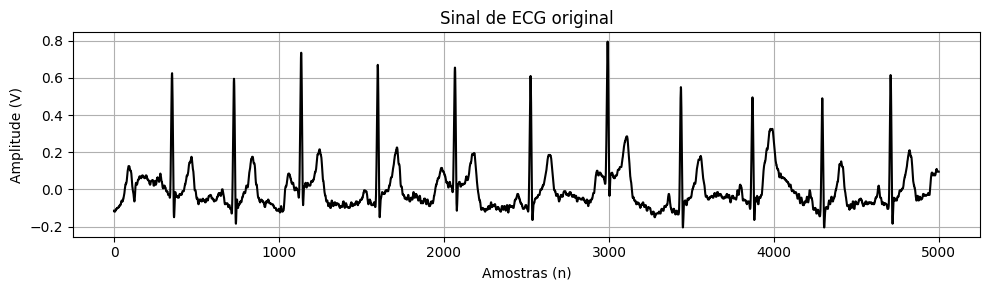

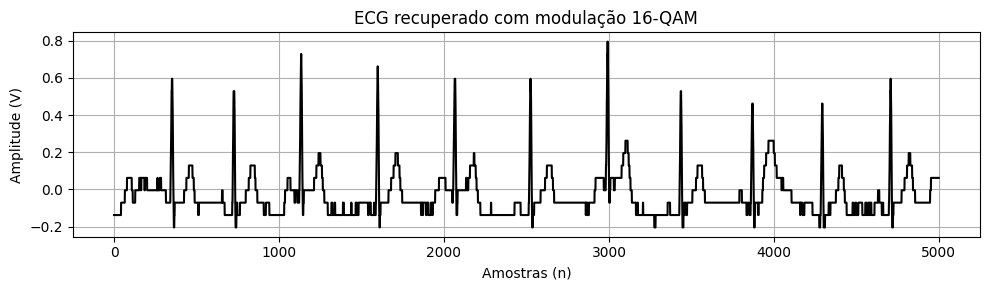

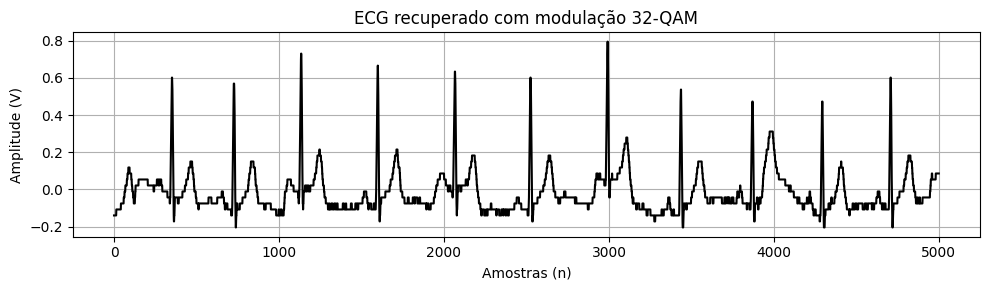

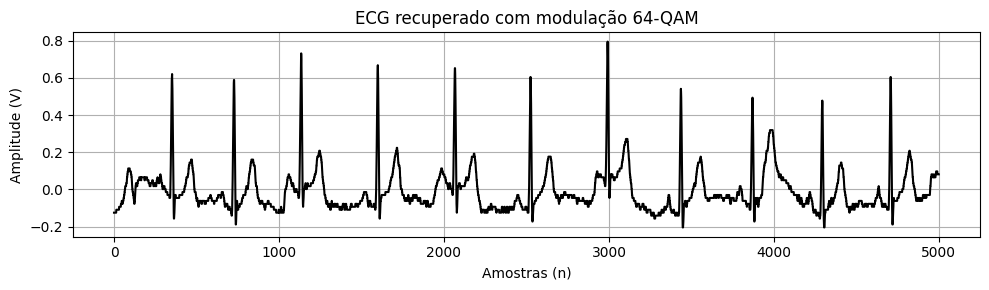

In [44]:
# Carrega o sinal de ECG (canal 1 = filtrado)
record = rdrecord('/content/drive/MyDrive/ECG/rec_1')
ecg_original = record.p_signal[:, 1][:5000]

# Aplica modulação e demodulação QAM
ecg_qam16 = qam_pipeline(ecg_original, 16, method="qam")
ecg_qam32 = qam_pipeline(ecg_original, 32, method="qam32")
ecg_qam64 = qam_pipeline(ecg_original, 64, method="qam")

# Plotagem dos resultados
start, end = 0, 5000
scale_16 = 1.0
scale_32 = 1.0
scale_64 = 1.0

# Sinal original
plt.figure(figsize=(10, 3))
plt.plot(ecg_original[start:end], color='black')
plt.title("Sinal de ECG original")
plt.xlabel("Amostras (n)")
plt.ylabel("Amplitude (V)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ecg_original.jpg", dpi=300)
plt.show()

# 16-QAM
plt.figure(figsize=(10, 3))
plt.plot(ecg_qam16[start:end] * scale_16, color='black')
plt.title("ECG recuperado com modulação 16-QAM")
plt.xlabel("Amostras (n)")
plt.ylabel("Amplitude (V)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ecg_qam16.jpg", dpi=300)
plt.show()

# 32-QAM
plt.figure(figsize=(10, 3))
plt.plot(ecg_qam32[start:end] * scale_32, color='black')
plt.title("ECG recuperado com modulação 32-QAM")
plt.xlabel("Amostras (n)")
plt.ylabel("Amplitude (V)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ecg_qam32.jpg", dpi=300)
plt.show()

# 64-QAM
plt.figure(figsize=(10, 3))
plt.plot(ecg_qam64[start:end] * scale_64, color='black')
plt.title("ECG recuperado com modulação 64-QAM")
plt.xlabel("Amostras (n)")
plt.ylabel("Amplitude (V)")
plt.grid(True)
plt.tight_layout()
plt.savefig("ecg_qam64.jpg", dpi=300)
plt.show()